In this study, we analyse digits MNIST dataset by performing dimensionality reduction using PCA. Algorithms for PCA and K-means will be written from scratch. We perform predictions at various reduced dimensions using K-Nearest Neighbors (KNN), linear Support Vector Machine (SVM) and also  K-means clustering algorithms.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

In [46]:
train = pd.read_csv('mnist_train.csv', header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
y_train = train.iloc[:,0].values
X_train = train.iloc[:,1:].values

In [48]:
test = pd.read_csv('mnist_test.csv', header=None)
X_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].values

## Task1

Write code for learning PCA parameters, i.e., mean vector and project matrix from the training data.

In [49]:
class custom_PCA():
    def __init__(self):
        pass
    
    def fit(self,n_components,X):
        self.n_components = n_components
        self.X = X
        
        #mean values for each feature
        meanvec = np.mean(self.X, axis=0)
        
        #subtract mean values
        X_sub = self.X - meanvec
        
        #covariance matrix
        C = np.cov(X_sub.T)
        
        #eigenvalues and eigenvectors of covariance matrix
        d,V = np.linalg.eig(C)
        
        #sort eigenvalues in descending order
        dsort = np.flip(np.sort(d))
        
        #get indices of sorted eigenvalues 
        dsort_ind = np.flip(np.argsort(d))
        
        #sort vectors corresponding to largest eigenvalues
        Vsort = V[:,dsort_ind][:,:self.n_components]
        
        #explained variance
        explained_variance = dsort[:self.n_components]
        
        #variance explined by each principal component as fraction of total variance
        explained_variance_ratio = (dsort/sum(dsort))[:self.n_components]
        
        
        self.meanvec = meanvec
        self.pca_components = Vsort
        self.dsort = dsort
        self.explained_variance = explained_variance
        self.explained_variance_ratio = explained_variance_ratio
        
    def transform(self,X_test):
        
        self.X_test = X_test
        
        #Subtract by mean values
        X_test_sub = self.X_test - self.meanvec
        
        #project on principal components
        X_transformed = self.pca_components.T.dot(X_test_sub.T)
        
        return np.real(X_transformed.T)

def screeplot(n_components,explained_variance_ratio, ax=None):
    x = np.arange(1,n_components+1)
    y = explained_variance_ratio
    plt.figure(figsize=(8,6))
    if ax is None:
        ax=plt.gca()
    ax.plot(x,y)
    ax.set_xlabel('Principal Components', fontsize=12)
    ax.set_ylabel('Variance',fontsize=12)
    return ax        
         
def varianceplot(n_components,explained_variance_ratio, ax=None, label=None):
    x = np.arange(1,n_components+1)
    y = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8,6))
    if ax is None:
        ax=plt.gca()
    ax.plot(x,y, label=label)
    ax.set_xlabel('Principal Components', fontsize=12)
    ax.set_ylabel('Cumulative variance',fontsize=12)
    if label:
        ax.legend(fontsize=12)
    return ax        

### Compare custom PCA with Scikit-learn library PCA

In [50]:
pca = custom_PCA()
pca.fit(n_components=256,X=X_train)
X_train_red = pca.transform(X_train)
X_test_red = pca.transform(X_test)
custom_expvar_ratio = pca.explained_variance_ratio

In [51]:
#fit transform X_train using Scikit-library PCA 
from sklearn.decomposition import PCA 
skpca = PCA(256) 
sk_Xtrain_red = skpca.fit_transform(X_train)
sk_expvar_ratio = skpca.explained_variance_ratio_

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


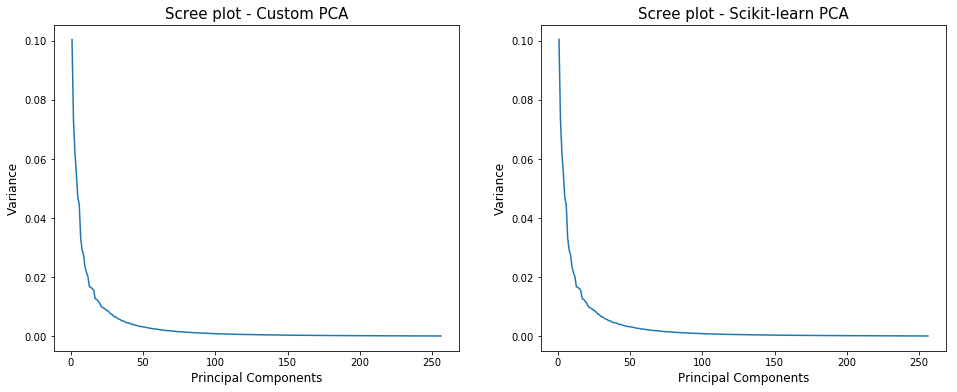

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [52]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize = (16,6))
screeplot(256,custom_expvar_ratio,ax=ax1)
ax1.set_title('Scree plot - Custom PCA',fontsize=15)
screeplot(256,sk_expvar_ratio,ax=ax2)
ax2.set_title('Scree plot - Scikit-learn PCA', fontsize=15);

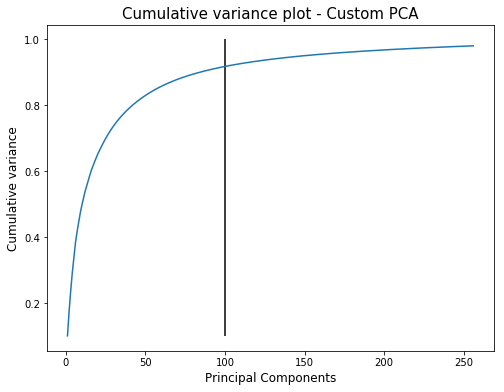

In [53]:
#variance plot using custom PCA
varianceplot(256,custom_expvar_ratio)
plt.title('Cumulative variance plot - Custom PCA', fontsize=15)
plt.vlines(x=100, ymin=0.1,ymax=1.0);

## Task2

Apply PCA to both training and testing set. Then perform classification with the 1- nearest neighbour classifier. Analyse the performance change against different reduced dimensions. 

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
trainaccs = []
testaccs = []
for components in range(256,6,-4):
    pca = custom_PCA()
    pca.fit(components,X_train)
    X_train_red = pca.transform(X_train)
    X_test_red = pca.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(X_train_red,y_train)
    X_train_pred = knn.predict(X_train_red)
    X_train_acc = accuracy_score(X_train_pred,y_train)
    X_test_pred = knn.predict(X_test_red)
    X_test_acc = accuracy_score(X_test_pred,y_test)
    trainaccs.append(X_train_acc)
    testaccs.append(X_test_acc)
    

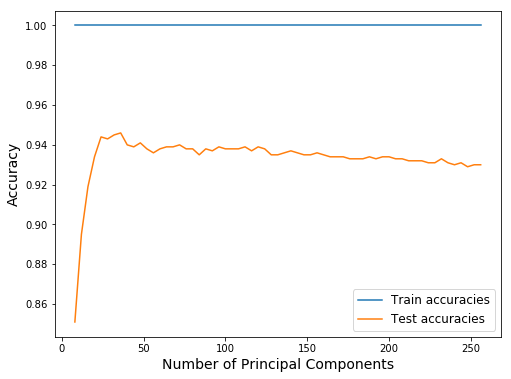

In [55]:
components = np.arange(256,6,-4)
plt.figure(figsize=(8,6))
plt.plot(components,trainaccs, label='Train accuracies')
plt.plot(components, testaccs, label = 'Test accuracies')
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

#plt.title('1-nearest neighbors with different reduced dimensions', fontsize=16)
plt.legend(fontsize=12);

## Task 3

Write code for implementing k-means clustering. Apply k-means clustering to the MNIST training set without dimensionality reduction. Plot the loss curve, that is, the change of loss value of k-means algorithm with respect to the number of iterations.

### Helper functions for k-means clustering algorithm 

In [56]:
def compute_random_centroids(X,k,random_seed):
    """returns a list of 10 randomly chosen datapoints"""
    np.random.seed(random_seed)
    for c in range(k):
        random_centroid_idx = list(np.random.choice(X.shape[0],size=k,replace=False))
        random_centroids = [X[centroid_id,:] for centroid_id in random_centroid_idx]
    
    return random_centroids
    
    
def compute_class_centroids(X,y,k,random_seed):
    """returns a list of randomly chosen datapoints representing each class"""
    np.random.seed(random_seed) 
    classes = list(np.arange(k,dtype='float'))
    class_centroids = []
    for c in classes:
        subset = np.where(y == c)[0]
        centroid_id = np.random.choice(subset)
        centroid = X[centroid_id,:].reshape(1,-1)
        class_centroids.append(centroid)
             
    return class_centroids    
    
   
    
def assign_clusters(X,centroids):
    """calculates euclidean distance from each centroid to each datapoint.
    The datapoint is assigned the to the cluster of the closest centroid. 
    Function returns a dataframe with cluster_id assigned for each datapoint """
    
    distances = np.empty(shape=(X.shape[0],len(centroids)))
    for c in range(len(centroids)):
        distance_array = np.linalg.norm(centroids[c]-X,axis=1)
        distances[:,c] = distance_array
    cluster_id = distances.argmin(axis=1)
    df = pd.DataFrame(X)
    df['cluster_id'] = cluster_id
        
    return df 


def compute_loss_percenterror(df,centroids):
    """compute mean sum of squared error"""
    sum_squares = []
    for c in range(len(centroids)):
        df_subset= df[df['cluster_id'] == c]
        squared_error = np.sum(np.linalg.norm(df_subset.iloc[:,:-1] - df_subset.iloc[:,:-1].mean())**2)
        sum_squares.append(squared_error)  
    return sum(sum_squares)

def compute_average_percentloss(df,k,labels):
    """compute percentage error in class prediction"""
    classes = list(np.arange(k,dtype='float'))
    percent_errors = []
    for c in classes:
        trueind = np.where(labels == c)[0]
        df_subset = df.iloc[trueind,:]
        error = len(df_subset[df_subset['cluster_id'] != c])*100/len(trueind)
        percent_errors.append(error)
    return mean(percent_errors)


def update_centroids(k,df):
    """Function sorts the dataframe to compute clusters belonging to each class and 
    calculates centre (mean) of each cluster. 
    The new centroids are the centres of clusters formed in previous iteration.
    """
    classes = list(np.arange(k,dtype='float'))
    df_sorted = df.sort_values(['cluster_id'])
    new_centroids = []
    for c in classes:
        subset = df_sorted[df_sorted['cluster_id']== c]
        mean = subset.iloc[:,:-1].mean(axis=0)
        new_centroids.append(np.array(mean).reshape(1,-1))
    return new_centroids 
    
    
    
class kmeans():
    def __init__(self,k, random_seed):
        self.k = k
        self.random_seed = random_seed
        
    
    def fit(self,X,y,initial_centroids_method,iterations):
        self.X = X
        self.y = y
        self.initial_centroids_method = initial_centroids_method
        self.iterations = iterations
        
        if self.initial_centroids_method == 'random':
            initial_centroids = compute_random_centroids(self.X,self.k,self.random_seed)
            
        elif self.initial_centroids_method == 'class':
            initial_centroids = compute_class_centroids(self.X,self.y,self.k,self.random_seed)
    
    
        centroids = initial_centroids
        avg_errors = []
        losses = []
        for i in range(self.iterations):
            df = assign_clusters(self.X,centroids)
            error = compute_average_percentloss(df,self.k,self.y)
            avg_errors.append(error)
            loss = compute_loss_percenterror(df,centroids)
            losses.append(loss)
            new_centroids = update_centroids(self.k,df)
            if all([np.allclose(x, y) for x, y in zip(new_centroids, centroids)]):
                break
            else:    
                centroids=new_centroids
                
                
        self.centroids = centroids
        self.errors = avg_errors
        self.losses = losses
        
     
    def predict(self,X_test):
        self.X_test = X_test
        df_test = assign_clusters(self.X_test,self.centroids)
        y_pred = df_test['cluster_id']
        
        return y_pred

In [57]:
trainaccs_random = []
testaccs_random = []
classifier_objects = []
for r in range(3):
    clf = kmeans(k=10,random_seed=r)
    clf.fit(X_train,y_train,initial_centroids_method='random',iterations=100)
    classifier_objects.append(clf)
    trainpred = clf.predict(X_train)
    testpred = clf.predict(X_test)
    trainacc = accuracy_score(trainpred,y_train)
    testacc = accuracy_score(testpred,y_test)
    trainaccs_random.append(trainacc)
    testaccs_random.append(testacc)


In [58]:
print('Dataset without dimension reduction, Initial centroids completely random')
print()
for r in range(3):
    print('Train accuracy, random seed {0}: {1:.1f}%'.format(r,trainaccs_random[r]*100))
    print('Test accuracy, random seed {0}: {1:.1f}%'.format(r,testaccs_random[r]*100))
    print()



Dataset without dimension reduction, Initial centroids completely random

Train accuracy, random seed 0: 9.5%
Test accuracy, random seed 0: 9.7%

Train accuracy, random seed 1: 5.9%
Test accuracy, random seed 1: 5.4%

Train accuracy, random seed 2: 3.1%
Test accuracy, random seed 2: 3.5%



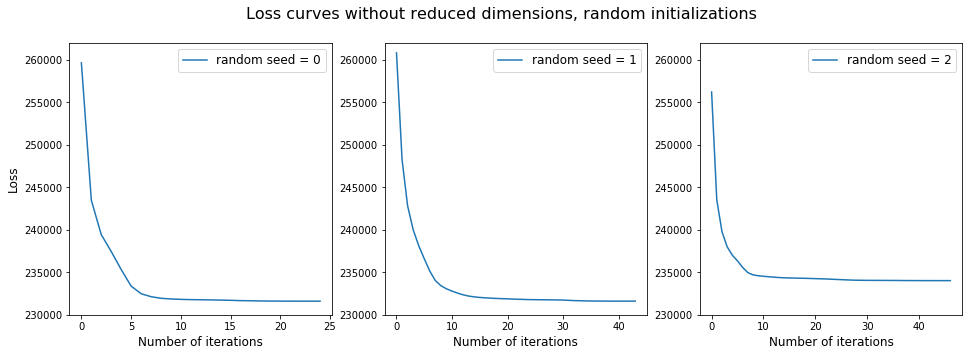

In [59]:
fig,[ax1,ax2,ax3] = plt.subplots(1,3, figsize=(16,5))
x = np.arange(len(classifier_objects[0].losses))
y = np.arange(len(classifier_objects[1].losses))
z = np.arange(len(classifier_objects[2].losses))
ax1.plot(x,classifier_objects[0].losses, label='random seed = 0')
ax1.set_xlabel('Number of iterations', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_ylim(230000,262000)
ax1.legend(fontsize=12)
ax2.plot(y,classifier_objects[1].losses, label = 'random seed = 1')
ax2.set_xlabel('Number of iterations', fontsize=12)
ax2.set_ylim(230000,262000)
ax2.legend(fontsize=12)
ax3.plot(z,classifier_objects[2].losses, label = 'random seed = 2')
ax3.set_xlabel('Number of iterations', fontsize=12)
ax3.set_ylim(230000,262000)
ax3.legend(fontsize=12)
plt.suptitle('Loss curves without reduced dimensions, random initializations', fontsize=16);

## Task 4 

Randomly choose one training sample from each class as initial clustering centres (so in total 10 centres). Performing k-means to group data into 10 groups with those initialized centres. For each cluster, calculate the percentage of samples sharing the same digit as the initial group centre. Average those percentages as an evaluation metric for k-means clustering. Repeat the above experiment with dimensionality reduced features and calculate the average percentage again. Note that you keep the initial clustering centres fixed through out those experiments. Analyse the performance change against different reduced dimensions. 

#### Without reduced dimensions

In [60]:
trainaccs_class = []
testaccs_class = []
classifier_objects = []
for r in range(3):
    clf = kmeans(k=10,random_seed=r)
    clf.fit(X_train,y_train,initial_centroids_method='class',iterations=100)
    classifier_objects.append(clf)
    trainpred = clf.predict(X_train)
    testpred = clf.predict(X_test)
    trainacc = accuracy_score(trainpred,y_train)
    testacc = accuracy_score(testpred,y_test)
    trainaccs_class.append(trainacc)
    testaccs_class.append(testacc)

In [61]:
print('Dataset without dimension reduction, Initial centroids from classes')
print()
for r in range(3):
    print('Train accuracy, random seed {0}: {1:.1f}%'.format(r,trainaccs_class[r]*100))
    print('Test accuracy, random seed {0}: {1:.1f}%'.format(r,testaccs_class[r]*100))
    print()



Dataset without dimension reduction, Initial centroids from classes

Train accuracy, random seed 0: 48.9%
Test accuracy, random seed 0: 46.9%

Train accuracy, random seed 1: 52.1%
Test accuracy, random seed 1: 54.1%

Train accuracy, random seed 2: 31.4%
Test accuracy, random seed 2: 30.5%



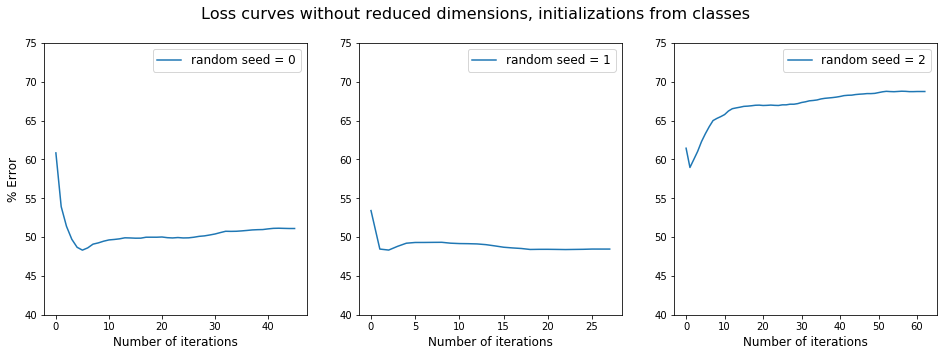

In [62]:
fig,[ax1,ax2,ax3] = plt.subplots(1,3, figsize=(16,5))
x = np.arange(len(classifier_objects[0].errors))
y = np.arange(len(classifier_objects[1].errors))
z = np.arange(len(classifier_objects[2].errors))
ax1.plot(x,classifier_objects[0].errors, label='random seed = 0')
ax1.set_xlabel('Number of iterations', fontsize=12)
ax1.set_ylabel('% Error', fontsize=12)
ax1.set_ylim(40,75)
ax1.legend(fontsize=12)
ax2.plot(y,classifier_objects[1].errors, label = 'random seed = 1')
ax2.set_xlabel('Number of iterations', fontsize=12)
ax2.set_ylim(40,75)
ax2.legend(fontsize=12)
ax3.plot(z,classifier_objects[2].errors, label = 'random seed = 2')
ax3.set_xlabel('Number of iterations', fontsize=12)
ax3.set_ylim(40,75)
ax3.legend(fontsize=12)
plt.suptitle('Loss curves without reduced dimensions, initializations from classes', fontsize=16);

In [63]:
clf2 = kmeans(k=10,random_seed = 0)
clf2.fit(X_train,y_train,initial_centroids_method = 'class', iterations=100)
trainpred_class = clf2.predict(X_train)
testpred_class = clf2.predict(X_test)
trainacc_class = accuracy_score(trainpred_class,y_train)
testacc_class = accuracy_score(testpred_class,y_test)
print('Dataset without dimension reduction, Initial centroids from each class')
print()
print('Train accuracy: {:.1f}%'.format(trainacc_class*100))
print('Test accuracy: {:.1f}%'.format(testacc_class*100))

Dataset without dimension reduction, Initial centroids from each class

Train accuracy: 48.9%
Test accuracy: 46.9%


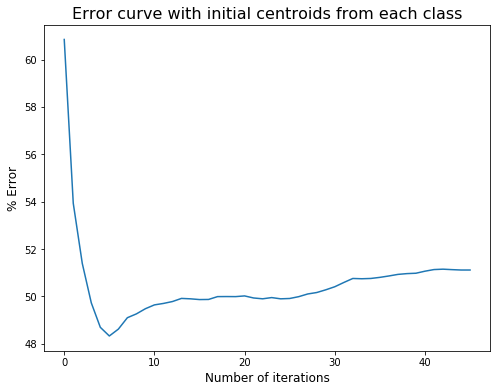

In [64]:
plt.figure(figsize=(8,6))        
x = np.arange(len(clf2.errors))
plt.plot(x,clf2.errors)
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('% Error', fontsize=12)
plt.title('Error curve with initial centroids from each class', fontsize=16);     

#### With Dimension reduction

In [65]:
trainerrors = []

for components in range(256,4,-6):
    pca = custom_PCA()
    pca.fit(components,X_train)
    X_train_red = pca.transform(X_train)
    clf = kmeans(k=10,random_seed=1)
    clf.fit(X_train_red,y_train, initial_centroids_method='class',iterations=100)
    trainpred = clf.predict(X_train_red)
    trainerror = clf.errors[-1]
    trainerrors.append(trainerror)
       

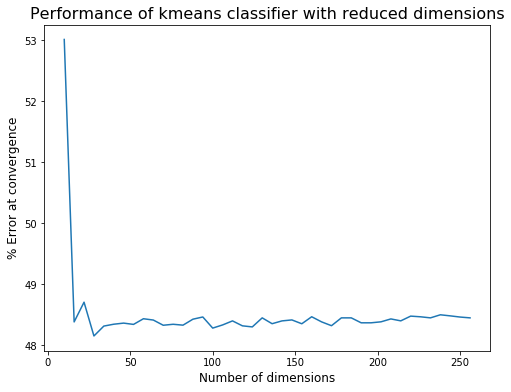

In [66]:
plt.figure(figsize=(8,6))
components = list(range(256,4,-6))
plt.plot(components,trainerrors)
plt.xlabel('Number of dimensions',fontsize=12)
plt.ylabel('% Error at convergence',fontsize=12);
plt.title('Performance of kmeans classifier with reduced dimensions',fontsize=16);

## Task 5

Append 256 noisy dimensions to the original data, that is, for each sample xi, appending a 256-dimensional random feature vector to xi to make it a 1040-dimensional feature. Then repeat the PCA classification experiments by using 1-nearest classifier and a linear SVM as classifiers. Test and analyse the results.

In [67]:
random_matrix = np.random.standard_normal(size=(X_train.shape[0] + X_test.shape[0],256))
random_train = random_matrix[:X_train.shape[0],:]
random_test = random_matrix[X_train.shape[0]::,:]
Xtrain_noisy = np.hstack((X_train,random_train))
Xtest_noisy = np.hstack((X_test,random_test))
print(Xtrain_noisy.shape)
print(Xtest_noisy.shape)

(6000, 1040)
(1000, 1040)


### PCA with noisy dataset

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 576x432 with 0 Axes>

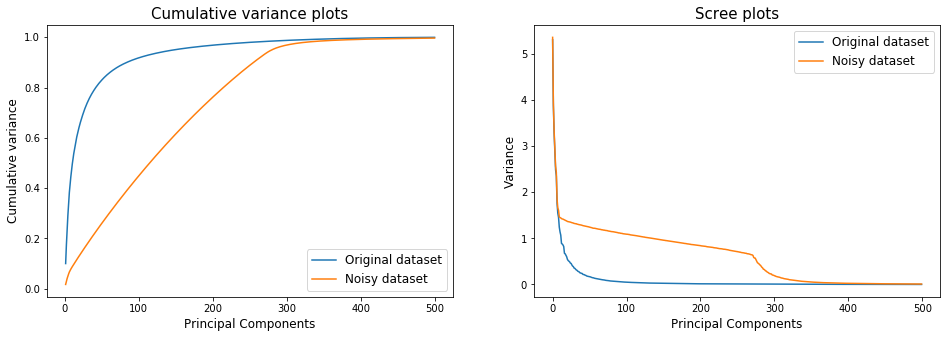

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [68]:
#Comapre PCA for original and noisy datasets
pca1 = custom_PCA()
pca1.fit(n_components = 500, X = X_train)
original_var = pca1.explained_variance_ratio
pca2 = custom_PCA()
pca2.fit(n_components=500,X = Xtrain_noisy)
noisy_var= pca2.explained_variance_ratio
plt.figure(figsize=(8,6))
fig,[ax1,ax2] = plt.subplots(1,2, figsize=(16,5))
varianceplot(500,original_var, ax=ax1, label='Original dataset')
varianceplot(500,noisy_var,ax=ax1, label='Noisy dataset')
ax1.set_title('Cumulative variance plots',fontsize=15)
x = np.arange(500)
ax2.plot(x,np.real(pca1.dsort[:500]), label='Original dataset')
ax2.plot(x,np.real(pca2.dsort[:500]), label = 'Noisy dataset')
ax2.set_xlabel('Principal Components',fontsize=12)
ax2.set_ylabel('Variance', fontsize=12)
ax2.set_title('Scree plots',fontsize=15)
ax2.legend(fontsize=12);

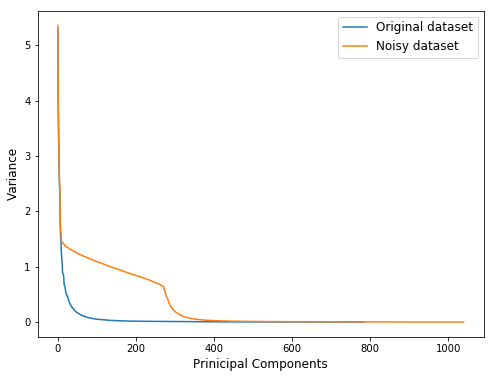

In [69]:
#compare variances of principal components for original and noisy datasets
plt.figure(figsize=(8,6))
plt.plot(np.real(pca1.dsort), label = 'Original dataset')
plt.plot(np.real(pca2.dsort), label = 'Noisy dataset')
plt.xlabel('Prinicipal Components', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.legend(fontsize=12);

PCA is sensitive to noise. With addition of Gaussian noisy features, PCA assumes that ~300 principal components are required to explain the variance of the dataset. Since we added 256 noisy features of variance 1, PCA is unable to discriminate between the noisy dimensions and signal dimensions that have a variance close to 1.

### Nearest Neighbors comparison of original and noisy dataset

In [70]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train,y_train)
trainpred_knn = knn1.predict(X_train)
testpred_knn = knn1.predict(X_test)
trainacc_knn = accuracy_score(trainpred_knn,y_train)
testacc_knn = accuracy_score(testpred_knn,y_test)
print('Performance of 1-Nearest Neighbors Classifier with original dataset, without PCA')
print()
print('Train accuracy : {:.1f} %'.format(trainacc_knn*100))
print('Test accuracy : {:.1f} %'.format(testacc_knn*100))

Performance of 1-Nearest Neighbors Classifier with original dataset, without PCA

Train accuracy : 100.0 %
Test accuracy : 92.8 %


In [71]:
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(Xtrain_noisy,y_train)
trainpred_knn_noisy = knn2.predict(Xtrain_noisy)
testpred_knn_noisy = knn2.predict(Xtest_noisy)
trainacc_knn_noisy = accuracy_score(trainpred_knn_noisy,y_train)
testacc_knn_noisy = accuracy_score(testpred_knn_noisy,y_test)
print('Performance of 1-Nearest Neighbors Classifier with noisy dataset, without PCA')
print()
print('Train accuracy : {:.1f} %'.format(trainacc_knn_noisy*100))
print('Test accuracy : {:.1f} %'.format(testacc_knn_noisy*100))

Performance of 1-Nearest Neighbors Classifier with noisy dataset, without PCA

Train accuracy : 100.0 %
Test accuracy : 55.2 %


### Nearest Neighbors with PCA on noisy dataset

In [72]:
noisytrainaccs_nn = []
noisytestaccs_nn = []
for components in range(1,300,20):
    pca = custom_PCA()
    pca.fit(components,Xtrain_noisy)
    X_train_red = pca.transform(Xtrain_noisy)
    X_test_red = pca.transform(Xtest_noisy)
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(X_train_red,y_train)
    X_train_pred = knn.predict(X_train_red)
    X_train_acc = accuracy_score(X_train_pred,y_train)
    X_test_pred = knn.predict(X_test_red)
    X_test_acc = accuracy_score(X_test_pred,y_test)
    noisytrainaccs_nn.append(X_train_acc)
    noisytestaccs_nn.append(X_test_acc)
    

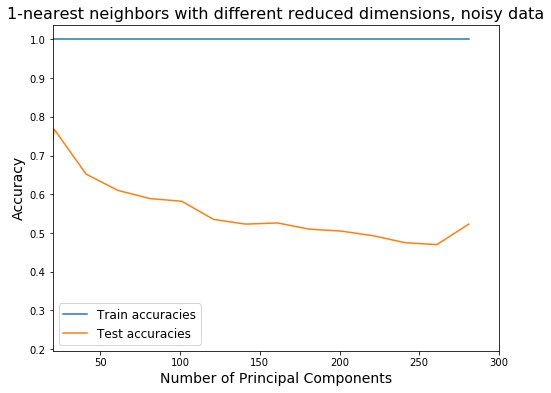

In [73]:
components = np.arange(1,300,20)
plt.figure(figsize=(8,6))
plt.plot(components,noisytrainaccs_nn, label='Train accuracies')
plt.plot(components, noisytestaccs_nn, label = 'Test accuracies')
plt.xlabel('Number of Principal Components', fontsize=14)
plt.xlim(20,300)
plt.ylabel('Accuracy', fontsize=14)
plt.title('1-nearest neighbors with different reduced dimensions, noisy data', fontsize=16)
plt.legend(fontsize=12);

### Linear SVM

In [74]:
#linear SVM with original dataset
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svc = SVC(kernel='linear')
params = [{'C': [1e-3,1e-2,1e-1,1]}]
clf1 = GridSearchCV(svc, params,cv=5, scoring = 'accuracy')
clf1.fit(X_train,y_train)
trainpred_svc = clf1.predict(X_train)
testpred_svc = clf1.predict(X_test)
trainacc_svc = accuracy_score(trainpred_svc,y_train)
testacc_svc = accuracy_score(testpred_svc,y_test)
print('Performance of linear SVM with original dataset')
print()
print('Train accuracy: {:.1f} %'.format(trainacc_svc*100))
print('test accuracy: {:.1f} %'.format(testacc_svc*100))

Performance of linear SVM with original dataset

Train accuracy: 98.1 %
test accuracy: 93.0 %


In [75]:
params = [{'C': [1e-3,1e-2,1e-1,1]}]
clf2 = GridSearchCV(svc, params,cv=5, scoring = 'accuracy')
clf2.fit(Xtrain_noisy,y_train)
trainpred_svc_noisy = clf2.predict(Xtrain_noisy)
testpred_svc_noisy = clf2.predict(Xtest_noisy)
trainacc_svc_noisy = accuracy_score(trainpred_svc_noisy,y_train)
testacc_svc_noisy = accuracy_score(testpred_svc_noisy,y_test)
print('Performance of linear SVM with noisy dataset')
print()
print('Train accuracy: {:.1f} %'.format(trainacc_svc_noisy*100))
print('Test accuracy: {:.1f} %'.format(testacc_svc_noisy*100))


Performance of linear SVM with noisy dataset

Train accuracy: 92.0 %
Test accuracy: 88.1 %


In [76]:
print(clf2.best_params_)

{'C': 0.001}


In [77]:
noisytrainaccs = []
noisytestaccs = []
for components in range(1,300,20):
    pca = custom_PCA()
    pca.fit(components,Xtrain_noisy)
    X_train_red = pca.transform(Xtrain_noisy)
    X_test_red = pca.transform(Xtest_noisy)
    svc = SVC(kernel='linear',C=0.001)
    svc.fit(X_train_red,y_train)
    X_train_pred = svc.predict(X_train_red)
    X_train_acc = accuracy_score(X_train_pred,y_train)
    X_test_pred = svc.predict(X_test_red)
    X_test_acc = accuracy_score(X_test_pred,y_test)
    noisytrainaccs.append(X_train_acc)
    noisytestaccs.append(X_test_acc)
    

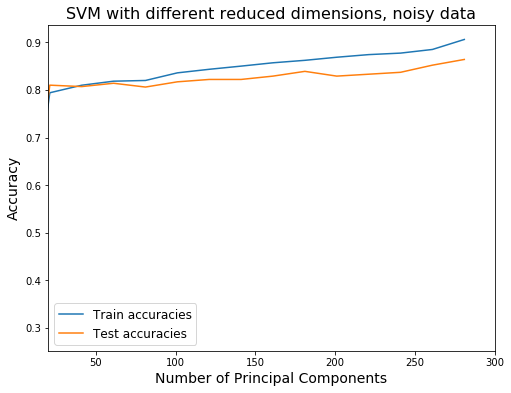

In [78]:
components = np.arange(1,300,20)
plt.figure(figsize=(8,6))
plt.plot(components,noisytrainaccs, label='Train accuracies')
plt.plot(components, noisytestaccs, label = 'Test accuracies')
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlim(20,300)
plt.title('SVM with different reduced dimensions, noisy data', fontsize=16)
plt.legend(fontsize=12);

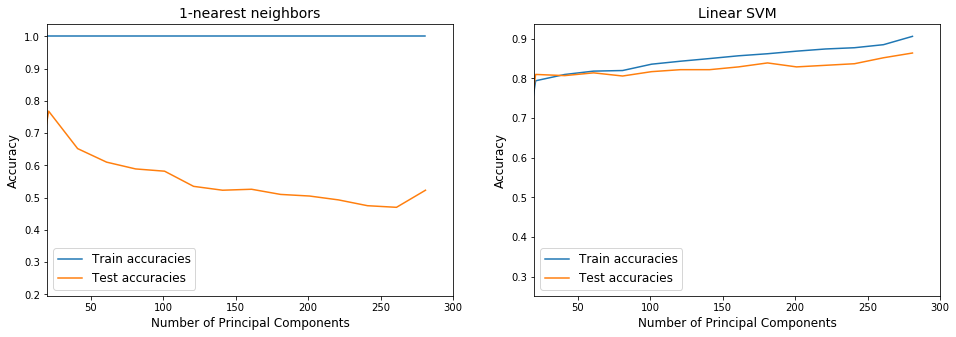

<Figure size 576x432 with 0 Axes>

In [79]:
fig,[ax1,ax2] = plt.subplots(1,2, figsize=(16,5))
components = np.arange(1,300,20)
plt.figure(figsize=(8,6))
ax1.plot(components,noisytrainaccs_nn, label='Train accuracies')
ax1.plot(components, noisytestaccs_nn, label = 'Test accuracies')
ax1.set_xlabel('Number of Principal Components', fontsize=12)
ax1.set_xlim(20,300)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('1-nearest neighbors', fontsize=14)
ax1.legend(fontsize=12)
ax2.plot(components,noisytrainaccs, label='Train accuracies')
ax2.plot(components, noisytestaccs, label = 'Test accuracies')
ax2.set_xlabel('Number of Principal Components', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Linear SVM', fontsize=14)
ax2.set_xlim(20,300)
ax2.legend(fontsize=12);
